In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
from IPython.display import display
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

### Ejercicio 1:

In [2]:
from sklearn.model_selection import KFold, cross_validate, cross_val_predict
from sklearn.tree import DecisionTreeClassifier

def cargar_datos():
    df = pd.read_csv('../data/data.csv')
    data = df.drop("target", axis=1)
    target = df.target
    return data.to_numpy(), target.to_numpy()

X, y = cargar_datos()

Veamos la distribucion de clases en todo el dataset

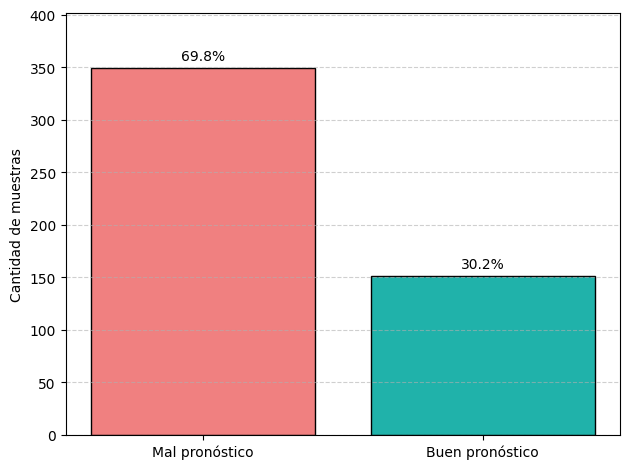

In [3]:
classes, counts = np.unique(y, return_counts=True)
percentages = counts / counts.sum() * 100

class_labels = ['Mal pronóstico' if c == 0 else 'Buen pronóstico' for c in classes]
bars = plt.bar(class_labels, counts, color=['lightcoral', 'lightseagreen'], edgecolor='black')

for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + counts.sum() * 0.01, f'{pct:.1f}%', 
             ha='center', va='bottom', fontsize=10)

plt.ylabel('Cantidad de muestras')
#plt.title('Distribución de clases en el dataset completo')
plt.ylim(0, max(counts) * 1.15)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [4]:
from sklearn.utils import shuffle

def eval_test_split(data, target, percentage):
    indices = shuffle(np.arange(len(data)), random_state=42)    # defino random_state para que el resultado sea el mismo en distintas iteraciones
    data = data[indices]
    target = target[indices]

    y_eval = []
    X_eval = []
    y_train = []
    X_train = []
    
    no_size_eval = round((target == 0).sum() * percentage)
    yes_size_eval = round((target == 1).sum() * percentage)
    
    for i in range(len(data)):
        if target[i] == 0:
            if no_size_eval > 0:
                X_eval.append(data[i])
                y_eval.append(target[i])
                no_size_eval = no_size_eval -1
            else:
                X_train.append(data[i])
                y_train.append(target[i])
        else:
            if yes_size_eval > 0:
                X_eval.append(data[i])
                y_eval.append(target[i])
                yes_size_eval = yes_size_eval -1
            else:
                X_train.append(data[i])
                y_train.append(target[i])

    return np.array(y_eval), np.array(X_eval), np.array(y_train), np.array(X_train)

In [5]:
y_eval, X_eval, y_train, X_train = eval_test_split(X, y, 0.15)

Ahora veamos como quedo la distribucion de clases en el dataset de entrenamiento y el de validacion final

In [6]:
classes_eval, counts_eval = np.unique(y_eval, return_counts=True)
classes_train, counts_train = np.unique(y_train, return_counts=True)
percentages_eval = counts_eval / counts_eval.sum() * 100
percentages_train = counts_train / counts_train.sum() * 100

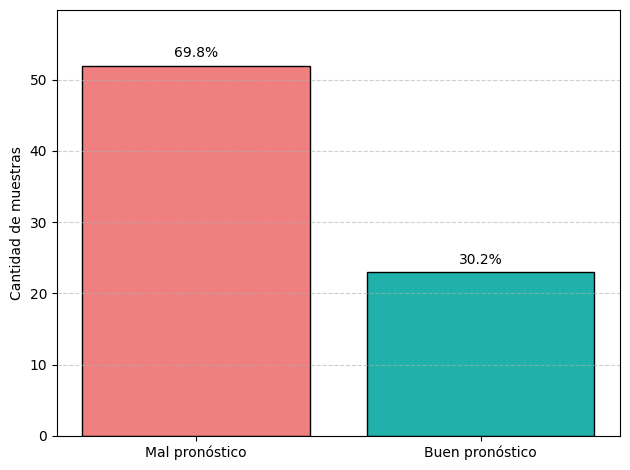

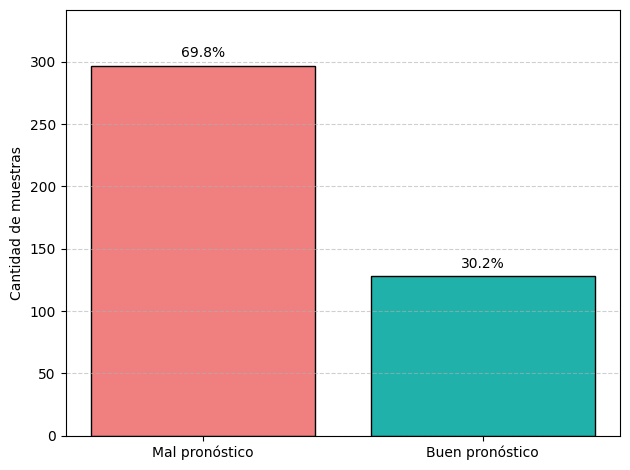

In [7]:
class_labels = ['Mal pronóstico' if c == 0 else 'Buen pronóstico' for c in classes_eval]
bars = plt.bar(class_labels, counts_eval, color=['lightcoral', 'lightseagreen'], edgecolor='black')

for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + counts_eval.sum() * 0.01, f'{pct:.1f}%', 
             ha='center', va='bottom', fontsize=10)

plt.ylabel('Cantidad de muestras')
#plt.title('Distribución de clases en el dataset de evaluación')
plt.ylim(0, max(counts_eval) * 1.15)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

class_labels = ['Mal pronóstico' if c == 0 else 'Buen pronóstico' for c in classes_train]
bars = plt.bar(class_labels, counts_train, color=['lightcoral', 'lightseagreen'], edgecolor='black')

for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + counts_train.sum() * 0.01, f'{pct:.1f}%', 
             ha='center', va='bottom', fontsize=10)

plt.ylabel('Cantidad de muestras')
#plt.title('Distribución de clases en el dataset de entrenamiento')
plt.ylim(0, max(counts_train) * 1.15)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [8]:
len(X_train)

425

Claramente la particion de datos esta manteniendo la distribucion de clases correctamente.

Podemos ver que las cantidades se adecuan a la distribucion que deben.

Nota sobre posible oversampling:


Hay un evidente desbalanceo entre las clases, esto nos puede perjudicar al entrenamiento del modelo, es mas facil aprender a predecir "mal pronostico".
Idealmente como trabajo futuro sobre este TP pensamos ahcer oversampling para evitar tener accuracy alto con predicciones erroneas de "buen pronostico".

## Ejercicio 2:

Para este punto, la tarea consiste en construir y evaluar modelos de tipo árbol de decisión. Además, obtener una estimación realista de la performance de los mismos.

##### 1. Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default. 

In [9]:
tree = DecisionTreeClassifier(max_depth=3, random_state=42)  # random_state para reproducibilidad entre iteraciones

# Generamos los 5 folds, para utilizar en todas las corridas de cross validation que realizamos.
# Especificamos valor de 'random_state' para que el resultado del shuffle sea reproducible (es decir, generar los mismos folds en distintas ejecuciones).
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

##### 2. Estimar la performance del modelo utilizando K-fold cross validation con K=5, con las métricas Accuracy, Area Under the Precision-Recall Curve (AUPRC), y Area Under the Receiver Operating Characteristic Curve (AUCROC). En esta oportunidad se va a pedir además de calcular las métricas para cada fold por separado y su promedio, que hagan el cálculo del score global (como vimos en clase), sólo para los folds de validación.

Calculamos primero las métricas para cada fold por separado, tanto para los folds de validación como los de entrenamiento. 

La función devuelve un diccionario, con las claves siendo la métrica (y si es test o train), y sus valores siendo arrays con los scores de cada fold.

Se utilizan como métricas:
* Accuracy (_accuracy_)
* Area Under the Precision-Recall Curve (AUPRC) (_average-precision_)
* Area Under the Receiver Operating Characteristic Curve (_roc auc_)

In [10]:
def scores_for_each_fold(cvfolds, tree, X, y, scoring_metrics):
    scores = cross_validate(tree, X, y, 
                            cv = cvfolds,
                            scoring = scoring_metrics, 
                            return_train_score=True     # incluir el score para los folds de entrenamiento también
                            )
    return scores

scoring_metrics = ['accuracy', 'roc_auc', 'average_precision'] # CHEQUEAR. consultar AUPRC -> average_precision
fold_scores = scores_for_each_fold(kfolds, tree, X_train, y_train, scoring_metrics)

In [11]:
fold_scores

{'fit_time': array([0.02065921, 0.01886892, 0.01880503, 0.01798582, 0.01770091]),
 'score_time': array([0.00276256, 0.00227427, 0.00218868, 0.00208378, 0.00199389]),
 'test_accuracy': array([0.58823529, 0.67058824, 0.64705882, 0.67058824, 0.65882353]),
 'train_accuracy': array([0.82352941, 0.80294118, 0.82647059, 0.82058824, 0.79411765]),
 'test_roc_auc': array([0.52033333, 0.63653274, 0.58482676, 0.64942529, 0.66427596]),
 'train_roc_auc': array([0.84654459, 0.8220288 , 0.83935769, 0.84005137, 0.8364366 ]),
 'test_average_precision': array([0.31115609, 0.33790582, 0.44593269, 0.41810073, 0.3757019 ]),
 'train_average_precision': array([0.65063302, 0.67387043, 0.6389291 , 0.67569252, 0.68150233])}

Ahora calculamos la métrica globalmente, calculandola para cada instancia usando el fold que no la vio en entrenamiento.

La función devuelve tanto predicciones (que necesita usar la métrica Accuracy y se calcula con __predict()__), como un array de probabilidades de las predicciones (que se usan en las otras dos métricas y se calcula con __predict_proba()__). Y luego con cada una de esas, se calcula el score para cada métrica pedida usando las funciones predefinidas de __sklearn.metrics__.

In [12]:
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

def global_predictions(model, folds, X, y):
    y_pred = np.zeros_like(y_train)
    y_proba_pred = np.zeros_like(y_train)
    for train_index, test_index in folds.split(X_train):
        current_X_train, current_y_train = X[train_index], y[train_index]
        current_X_test = X[test_index]

        current_tree = model.fit(current_X_train, current_y_train)
        y_pred[test_index] = current_tree.predict(current_X_test)
        y_proba_pred[test_index] = current_tree.predict_proba(current_X_test)[:,1]  

    return y_pred, y_proba_pred


y_pred, y_proba_pred = global_predictions(tree, kfolds, X_train, y_train)
global_scores = {'test_roc_auc': roc_auc_score(y_train, y_proba_pred),
                 'test_average_precision': average_precision_score(y_train, y_proba_pred),
                 'test_accuracy': accuracy_score(y_train, y_pred)
                }

In [13]:
global_scores

{'test_roc_auc': np.float64(0.5072074915824916),
 'test_average_precision': np.float64(0.3056535947712418),
 'test_accuracy': 0.6470588235294118}

In [14]:
scores_table = pd.DataFrame(fold_scores).drop(['fit_time', 'score_time'], axis=1)
scores_table.loc['Promedios'] = scores_table.mean()
scores_table.loc['Global'] = global_scores
scores_table

,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc,test_average_precision,train_average_precision
0,0.588235,0.823529,0.520333,0.846545,0.311156,0.650633
1,0.670588,0.802941,0.636533,0.822029,0.337906,0.673870
2,0.647059,0.826471,0.584827,0.839358,0.445933,0.638929
3,0.670588,0.820588,0.649425,0.840051,0.418101,0.675693
4,0.658824,0.794118,0.664276,0.836437,0.375702,0.681502
Promedios,0.647059,0.813529,0.611079,0.836884,0.377759,0.664125
Global,0.647059,NaN,0.507207,NaN,0.305654,NaN


Dado que nuestros datos están altamente imbalanceados, favoreciendo la clase negativa, comparemos con el desempeño de un DummyClassifier que predice siempre la clase más frecuente:

In [15]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='most_frequent')

scoring_metrics = ['accuracy', 'roc_auc', 'average_precision'] # CHEQUEAR. consultar AUPRC -> average_precision
dummy_fold_scores = scores_for_each_fold(kfolds, dummy, X_train, y_train, scoring_metrics)

y_dummy_pred, y_proba_dummy_pred = global_predictions(dummy, kfolds, X_train, y_train)
dummy_global_scores = {'test_roc_auc': roc_auc_score(y_train, y_proba_dummy_pred),
                 'test_average_precision': average_precision_score(y_train, y_proba_dummy_pred),
                 'test_accuracy': accuracy_score(y_train, y_dummy_pred)
                }

scores_table = pd.DataFrame(dummy_fold_scores).drop(['fit_time', 'score_time'], axis=1)
scores_table.loc['Promedios'] = scores_table.mean()
scores_table.loc['Global'] = dummy_global_scores
scores_table


,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc,test_average_precision,train_average_precision
0,0.705882,0.697059,0.5,0.5,0.294118,0.302941
1,0.752941,0.685294,0.5,0.5,0.247059,0.314706
2,0.635294,0.714706,0.5,0.5,0.364706,0.285294
3,0.682353,0.702941,0.5,0.5,0.317647,0.297059
4,0.717647,0.694118,0.5,0.5,0.282353,0.305882
Promedios,0.698824,0.698824,0.5,0.5,0.301176,0.301176
Global,0.698824,NaN,0.5,NaN,0.301176,NaN


##### 3. Explorar las siguientes combinaciones de parámetros para árboles de decisión (siguiendo con k-fold con k=5) utilizando ParameterGrid de scikit learn. No está permitido utilizar GridSearchCV en este ejercicio.

In [16]:
infinite = 2 ** 32

def evaluate_tree(criterion, param):
    tree = DecisionTreeClassifier(criterion=criterion, random_state=42, **param)
    scores = scores_for_each_fold(kfolds, tree, X_train, y_train, ['accuracy'])
    test_mean = scores['test_accuracy'].mean()
    train_mean = scores['train_accuracy'].mean()
    max_depth = param['max_depth']
    return {
        'Altura máxima': 'Infinito' if max_depth == infinite else max_depth,
        'Criterio': 'Entropía' if criterion == 'entropy' else 'Gini',
        'Accuracy (training)': train_mean,
        'Accuracy (validación)': test_mean
    }

In [17]:
from sklearn.model_selection import ParameterGrid

parameters = {'max_depth': [3, 5, infinite]}
param_grid = ParameterGrid(parameters)

results = []

for param in param_grid:
    results.append(evaluate_tree('gini', param))
    results.append(evaluate_tree('entropy', param))

results = pd.DataFrame(results)
results = results.sort_values(by=['Criterio', 'Altura máxima'], ascending=[False, True])
display(results)

,Altura máxima,Criterio,Accuracy (training),Accuracy (validación)
0,3,Gini,0.813529,0.647059
2,5,Gini,0.921176,0.670588
4,Infinito,Gini,1.000000,0.663529
1,3,Entropía,0.768235,0.665882
3,5,Entropía,0.892941,0.656471
5,Infinito,Entropía,1.000000,0.647059


# Ejercicio 3

Hacemos una busqueda de hiperparametros con RandomizedSearchCV

In [18]:
import matplotlib.cm as cm
def graficarResultados(search, nombre):
    resultados = pd.DataFrame(search.cv_results_)
    resultados = resultados[['params', 'mean_test_score']]

    n_top = min(6, len(resultados))
    top_resultados = resultados.sort_values(by='mean_test_score', ascending=False).head(n_top)

    top_resultados['param_str'] = top_resultados['params'].apply(lambda d: str(d))

    # un extra para que se vean colores mas fuertes por mejores metricas
    scores = top_resultados['mean_test_score'].values
    norm = (scores - scores.min()) / (scores.max() - scores.min())
    colores = cm.cool(norm)

    indices = ["Modelo "+str(i+1) for i in range(n_top)]
    top_resultados['index'] = indices

    plt.figure(figsize=(8, 6))
    bars = plt.bar(top_resultados['index'], top_resultados['mean_test_score'], color=colores, width=0.6)
    plt.ylabel('AUC-ROC (media 5-fold CV)')
    plt.title('Top combinaciones de hiperparámetros - ' + nombre)

    # Mostrar valor AUC encima de cada barra
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va='bottom')

    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    for idx, fila in top_resultados.iterrows():
        print(f"{fila['index']}: {fila['params']}")


In [19]:
treeclassify = DecisionTreeClassifier(random_state=0)

distributions = dict(max_depth=range(1,25), # el log2 de 425 es 9, que seria la altura del arbol balanceado, queriamos hacer algo mayor a eso
                     criterion=['gini', 'entropy', 'log_loss'], # gini y entropy pq son las vistas en clase, log_loss pq interesante
                     min_samples_split= [2, 5, 10], 
                     min_samples_leaf= [1, 2, 4],
                     max_features= [1, 3, 'sqrt', 'log2', None]) # con 1 probamos pq es lo visto en clase, y desp fuimos aumentando las opciones (none es no hay maximo)


clf = RandomizedSearchCV(treeclassify, distributions, scoring='roc_auc',  n_iter=50, random_state=0)
tree_search = clf.fit(X_train, y_train)
    
#nos lo guardamos para el ej 4
best_tree_params = tree_search.best_params_

Mejores hiperparámetros: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 6, 'criterion': 'entropy'}
Mejor AUC-ROC: 0.64581321164711


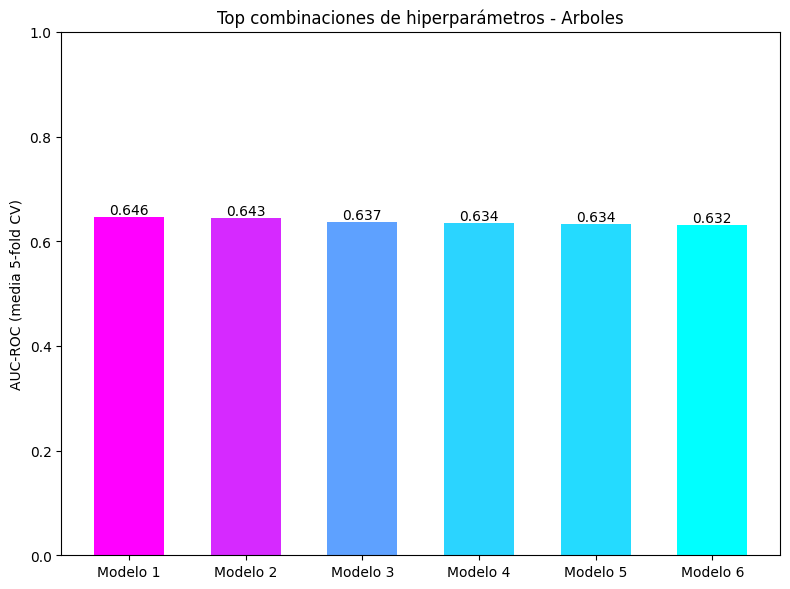

Modelo 1: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 6, 'criterion': 'entropy'}
Modelo 2: {'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 9, 'criterion': 'log_loss'}
Modelo 3: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 12, 'criterion': 'entropy'}
Modelo 4: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 12, 'criterion': 'log_loss'}
Modelo 5: {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 24, 'criterion': 'log_loss'}
Modelo 6: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 23, 'criterion': 'entropy'}


In [20]:
print("Mejores hiperparámetros:", tree_search.best_params_)
print("Mejor AUC-ROC:", tree_search.best_score_)
graficarResultados(tree_search, 'Arboles')
tree_score = tree_search.best_score_

c:\Users\Tobias\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Tobias\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


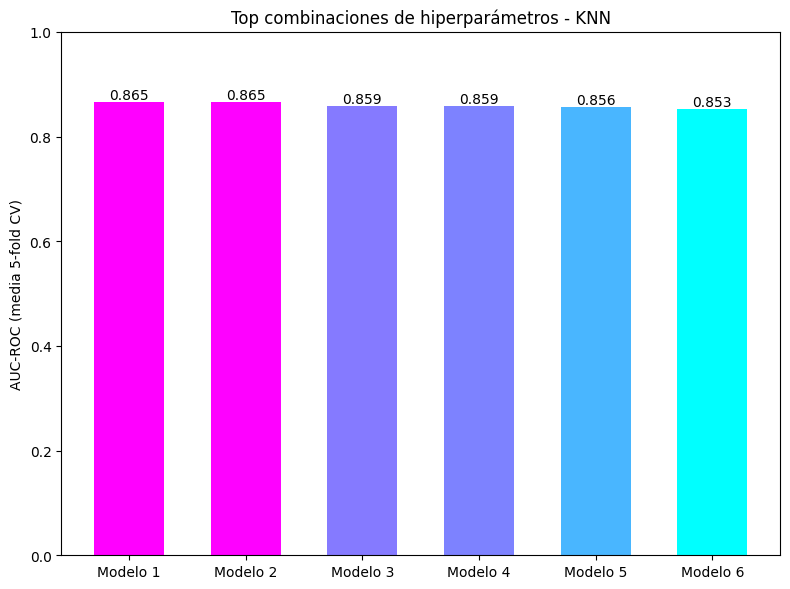

Modelo 1: {'p': 1, 'n_neighbors': 20, 'algorithm': 'brute'}
Modelo 2: {'p': 1, 'n_neighbors': 11, 'algorithm': 'kd_tree'}
Modelo 3: {'p': 1, 'n_neighbors': 15, 'algorithm': 'kd_tree'}
Modelo 4: {'p': 1, 'n_neighbors': 13, 'algorithm': 'brute'}
Modelo 5: {'p': 1, 'n_neighbors': 17, 'algorithm': 'ball_tree'}
Modelo 6: {'p': 1, 'n_neighbors': 27, 'algorithm': 'ball_tree'}


In [21]:
knn = KNeighborsClassifier()

param_dist_knn = {
    'n_neighbors': range(1, 30),
    'p': [1, 2],  # 1: Manhattan, 2: Euclidiana
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

knn_search = RandomizedSearchCV(knn, param_dist_knn, 
                                scoring='roc_auc', n_iter=20, random_state=0)
knn_search.fit(X_train, y_train)

best_knn_params = knn_search.best_params_

graficarResultados(knn_search, 'KNN')

knn_score = knn_search.best_score_

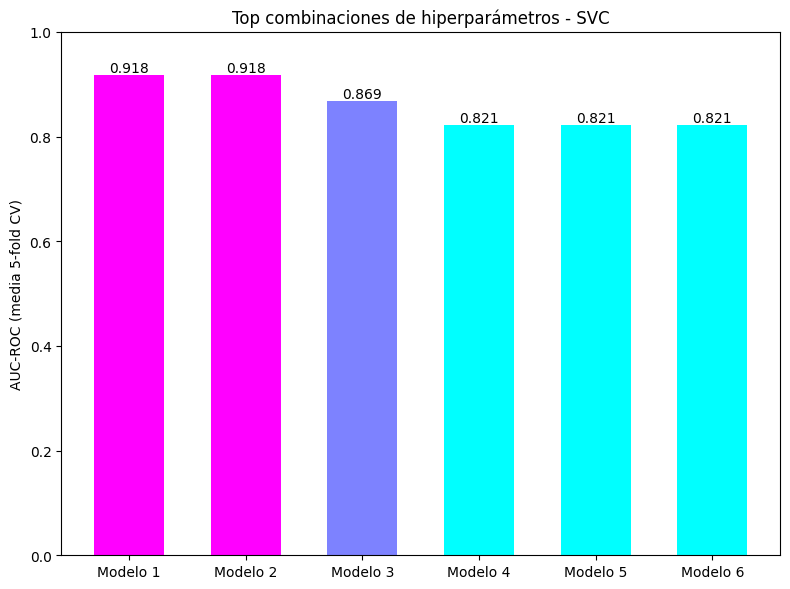

Modelo 1: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
Modelo 2: {'kernel': 'rbf', 'gamma': 'scale', 'C': 100}
Modelo 3: {'kernel': 'rbf', 'gamma': 'scale', 'C': 0.1}
Modelo 4: {'kernel': 'poly', 'gamma': 'auto', 'C': 10}
Modelo 5: {'kernel': 'poly', 'gamma': 'auto', 'C': 100}
Modelo 6: {'kernel': 'poly', 'gamma': 'auto', 'C': 0.1}


In [22]:
svc = svm.SVC(probability=True)

param_dist_svc = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

svc_search = RandomizedSearchCV(svc, param_dist_svc,
                                scoring='roc_auc', n_iter=20, random_state=0)
svc_search.fit(X_train, y_train)

best_svc_params = svc_search.best_params_

graficarResultados(svc_search, 'SVC')
svc_score = svc_search.best_score_

# los resultados muestran q siempre q usamos el kernel rbf, conviene el gamma scale, y que cuando usamos el kernel poly conviene usar auto, desp lo unico q varia es el c (igual el rdbf da mejor)

In [23]:
# LDA
lda = LinearDiscriminantAnalysis()
auc_lda = cross_val_score(lda, X_train, y_train, cv=5, scoring='roc_auc').mean()

# Naive Bayes
nb = GaussianNB()
auc_nb = cross_val_score(nb, X_train, y_train, cv=5, scoring='roc_auc').mean()

In [24]:
resultados_auc = {
    'Decision Tree': tree_score,
    'KNN': knn_score,
    'SVM': svc_score,
    'LDA (default)': auc_lda,
    'Naive Bayes (default)': auc_nb
}

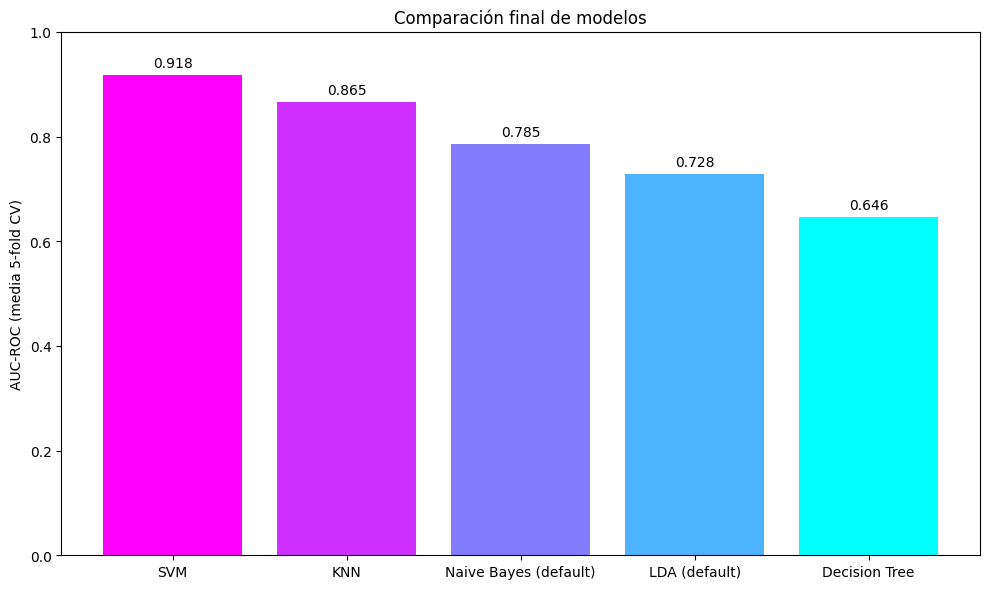

In [25]:
resultados_ordenados = dict(sorted(resultados_auc.items(), key=lambda item: item[1], reverse=True))

modelos = list(resultados_ordenados.keys())
scores = np.array(list(resultados_ordenados.values()))

# colores :)
norm = (scores - scores.min()) / (scores.max() - scores.min())
colores = cm.cool(norm)

plt.figure(figsize=(10, 6))
bars = plt.bar(modelos, scores, color=colores)
plt.ylim(0.0, 1.0)
plt.ylabel('AUC-ROC (media 5-fold CV)')
plt.title('Comparación final de modelos')
#plt.xticks(rotation=45)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Desde los searchs tree_search, knn_search y svc_search generados con RandomizedSearechCV. Hacemos un grafico de barras comparando todos los mejores modelos.

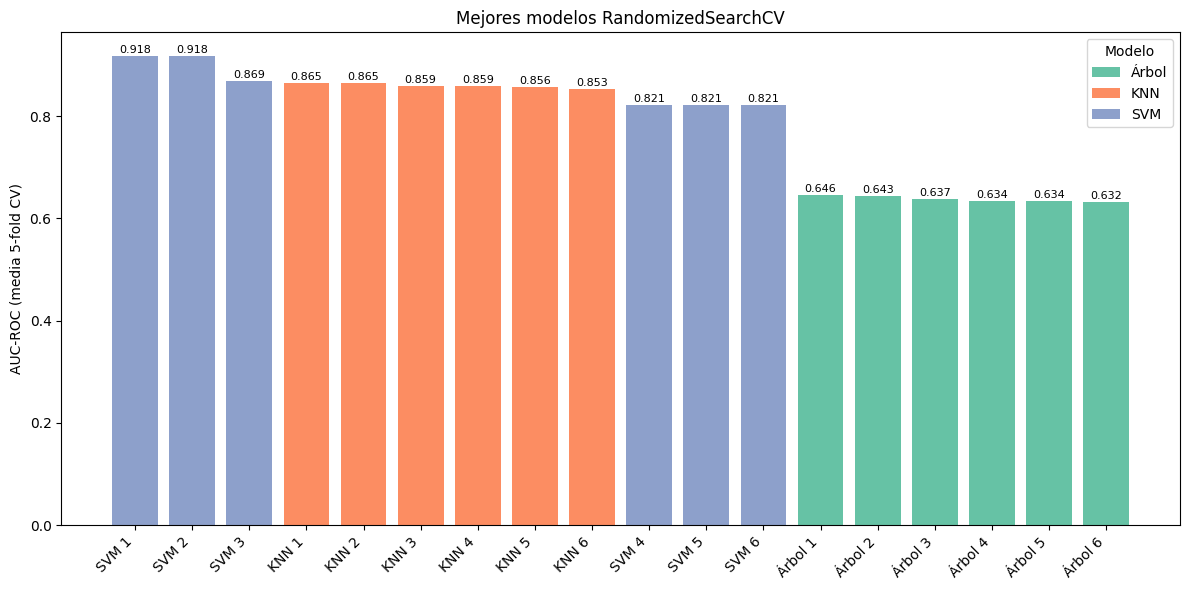

In [26]:
cantidad_modelos = 6

searches = [
    (tree_search, 'Árbol'),
    (knn_search, 'KNN'),
    (svc_search, 'SVM')
]

set2 = plt.get_cmap('Set2')
model_colors = {
    'Árbol': set2(0),
    'KNN': set2(1),
    'SVM': set2(2)
}

mejores = []

for search, nombre_modelo in searches:
    resultados = pd.DataFrame(search.cv_results_)
    top = resultados.sort_values('mean_test_score', ascending=False).head(cantidad_modelos)
    
    for i, (_, fila) in enumerate(top.iterrows()):
        mejores.append({
            'Modelo': f'{nombre_modelo} {i+1}',
            'AUC-ROC': fila['mean_test_score'],
            'Tipo': nombre_modelo
        })

df_plot = pd.DataFrame(mejores)
df_plot = df_plot.sort_values(by=['AUC-ROC', 'Modelo'], ascending=[False, True])
df_plot['Modelo'] = pd.Categorical(df_plot['Modelo'], categories=df_plot['Modelo'], ordered=True)

plt.figure(figsize=(12, 6))
bars = plt.bar(df_plot['Modelo'], df_plot['AUC-ROC'], color=df_plot['Tipo'].map(model_colors))

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.002, f'{height:.3f}', ha='center', va='bottom', fontsize=8)

legend_elements = [Patch(facecolor=color, label=label) for label, color in model_colors.items()]
plt.legend(handles=legend_elements, title='Modelo')

plt.xticks(rotation=45, ha='right')
plt.ylabel('AUC-ROC (media 5-fold CV)')
plt.title('Mejores modelos RandomizedSearchCV')
plt.tight_layout()
plt.show()

# Ejercicio 4

Seleccionemos 3 de los mejores modelos de cada una de las familias de modelos que previamente exploramos.

El mejor arbol, el mejor KNN y el mejor SVM.

In [27]:
mejor_arbol = DecisionTreeClassifier(**best_tree_params)
mejor_knn = KNeighborsClassifier(**best_knn_params)
mejor_SVM = svm.SVC(**best_svc_params, probability=True)

### Curvas de complejidad

Ahora queremos ver la curva de complejidad de estos modelos, en arboles es variar la altura, en KNN el numero de vecinos y en SVM el valor de C.

**Nota sobre la metrica:**

En los siguientes graficos calculamos el error como 1 - AUC-ROC, ya que entendemos el error como que tan mal nuestro modelo esta separando las clases.


Otra posibilidad que evaluamos es usar el error como 1 - Accurracy, que nos estaria dando el porcentaje de clasificaciones errones, pero como nuestro dataset esta desbalanceado 
no es una metrica muy indicativa para nuestro uso.

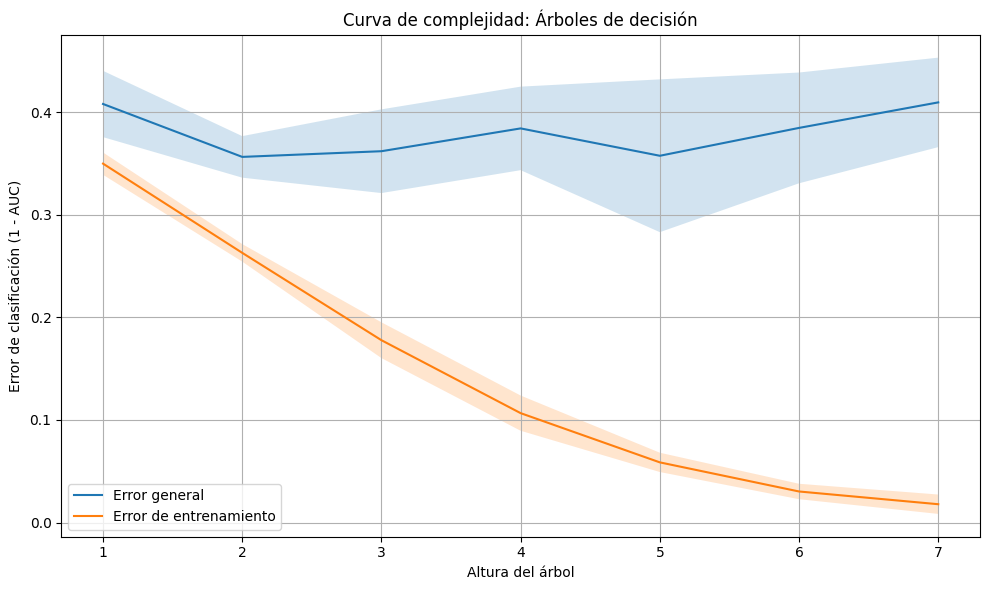

In [28]:
alturas = range(1, 8)
errores, errores_train = [], []
stds, stds_train  = [],[]

for altura in alturas:
    arbol_param = best_tree_params.copy()
    arbol_param["max_depth"] = altura
    arbol = DecisionTreeClassifier(**arbol_param)
    res_cross_val = cross_validate(
        arbol, X_train, y_train, cv=kfolds,
        scoring='roc_auc', return_train_score=True
    )
    accuracy = res_cross_val['test_score'].mean()
    accuracy_train = res_cross_val['train_score'].mean()
    std = res_cross_val['test_score'].std()
    std_train = res_cross_val['train_score'].std()

    errores.append(1 - accuracy)
    errores_train.append(1 - accuracy_train)
    stds.append(std)
    stds_train.append(std_train)

errores = np.array(errores)
errores_train = np.array(errores_train)
stds = np.array(stds)
stds_train = np.array(stds_train)

plt.figure(figsize=(10, 6))
# Error general
plt.plot(alturas, errores, label='Error general')
plt.fill_between(alturas, errores - stds, errores + stds, alpha=0.2)

# Error de entrenamiento
plt.plot(alturas, errores_train, label='Error de entrenamiento')
plt.fill_between(alturas, errores_train - stds_train, errores_train + stds_train, alpha=0.2)

plt.xlabel('Altura del árbol')
plt.ylabel('Error de clasificación (1 - AUC)')
plt.title('Curva de complejidad: Árboles de decisión')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


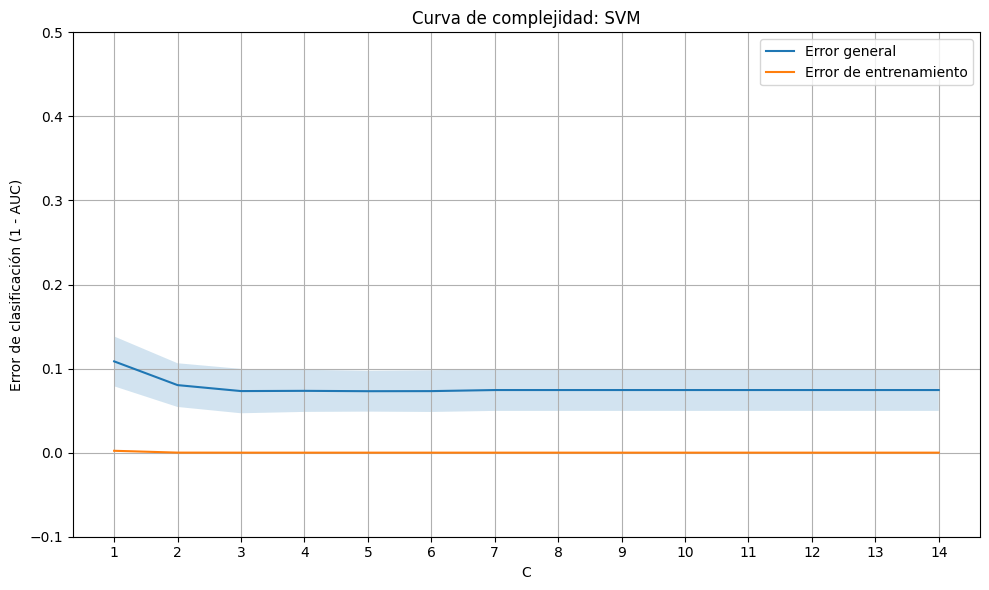

In [29]:
cs = range(1, 15)
errores = []
errores_train = []
stds = []
stds_train = []

for c in cs:
    cvm_param = best_svc_params.copy()
    cvm_param["C"] = c
    modelo = svm.SVC(**cvm_param)
    resCross = cross_validate(
        modelo, X_train, y_train, cv=kfolds,
        scoring='roc_auc', return_train_score=True
    )
    accuracy = resCross['test_score'].mean()
    accuracy_train = resCross['train_score'].mean()
    std = resCross['test_score'].std()
    std_train = resCross['train_score'].std()

    errores.append(1 - accuracy)
    errores_train.append(1 - accuracy_train)
    stds.append(std)
    stds_train.append(std_train)

errores = np.array(errores)
errores_train = np.array(errores_train)
stds = np.array(stds)
stds_train = np.array(stds_train)

plt.figure(figsize=(10, 6))
plt.plot(cs, errores, label='Error general')
plt.fill_between(cs, errores - stds, errores + stds, alpha=0.2)

plt.plot(cs, errores_train, label='Error de entrenamiento')
plt.fill_between(cs, errores_train - stds_train, errores_train + stds_train, alpha=0.2)

plt.xlabel('C')
plt.ylabel('Error de clasificación (1 - AUC)')
plt.title('Curva de complejidad: SVM')
plt.xticks(cs)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


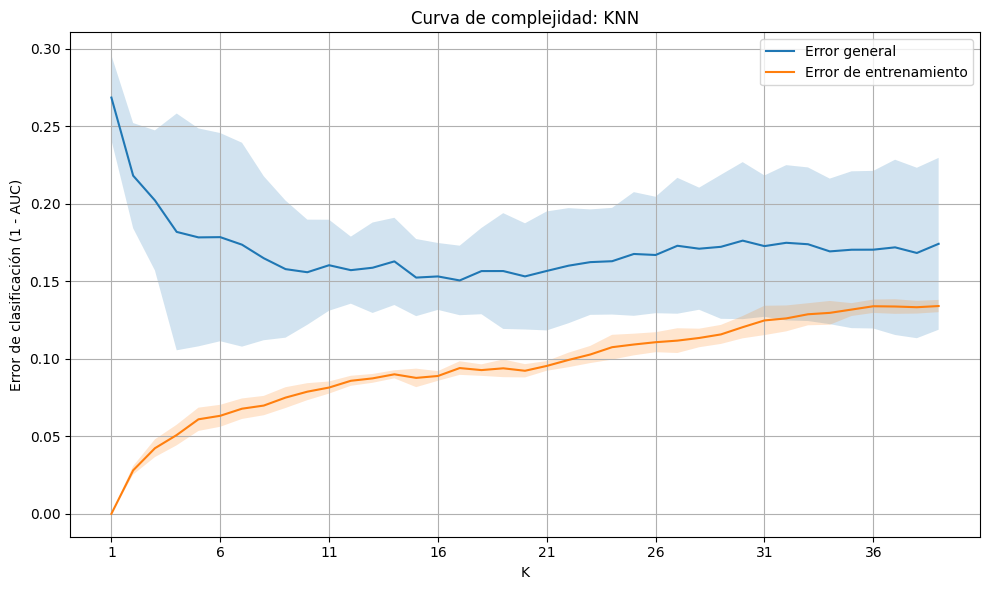

In [30]:
ks = range(1, 40)
errores = []
errores_train = []
stds = []
stds_train = []

for k in ks:
    knn_param = best_knn_params.copy()
    knn_param["n_neighbors"] = k
    modelo = KNeighborsClassifier(**knn_param)
    resCross = cross_validate(modelo, X_train, y_train, cv=kfolds, scoring='roc_auc', return_train_score=True)
    accuracy = resCross['test_score'].mean()
    accuracy_train = resCross['train_score'].mean()
    std = resCross['test_score'].std()
    std_train = resCross['train_score'].std()

    errores.append(1 - accuracy)
    errores_train.append(1 - accuracy_train)
    stds.append(std)
    stds_train.append(std_train)

errores = np.array(errores)
errores_train = np.array(errores_train)
stds = np.array(stds)
stds_train = np.array(stds_train)

plt.figure(figsize=(10, 6))
plt.plot(ks, errores, label='Error general')
plt.fill_between(ks, errores - stds, errores + stds, alpha=0.2)

plt.plot(ks, errores_train, label='Error de entrenamiento')
plt.fill_between(ks, errores_train - stds_train, errores_train + stds_train, alpha=0.2)

plt.xlabel('K')
plt.ylabel('Error de clasificación (1 - AUC)')
plt.title('Curva de complejidad: KNN')
plt.xticks(range(1, 40, 5))
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


## Curvas de aprendizaje

In [31]:
def graficar_curvas_aprendizaje(modelo, train_sizes=np.linspace(0.1,1.0,5)):
    train_size_abs, train_scores, test_scores = learning_curve(modelo, 
                                                  X_train, y_train, 
                                                  train_sizes=train_sizes,
                                                  scoring='roc_auc',
                                                  random_state=0
                                                  )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_size_abs, train_scores_mean, label='Datos de entrenamiento', color='blue', marker='o')
    plt.plot(train_size_abs, test_scores_mean, label='Datos de validación', color='darkorange', marker='o')

    plt.title('Curvas de aprendizaje: \n' + str(modelo))
    plt.xlabel('Cantidad de muestras')
    plt.ylabel('AUC ROC')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

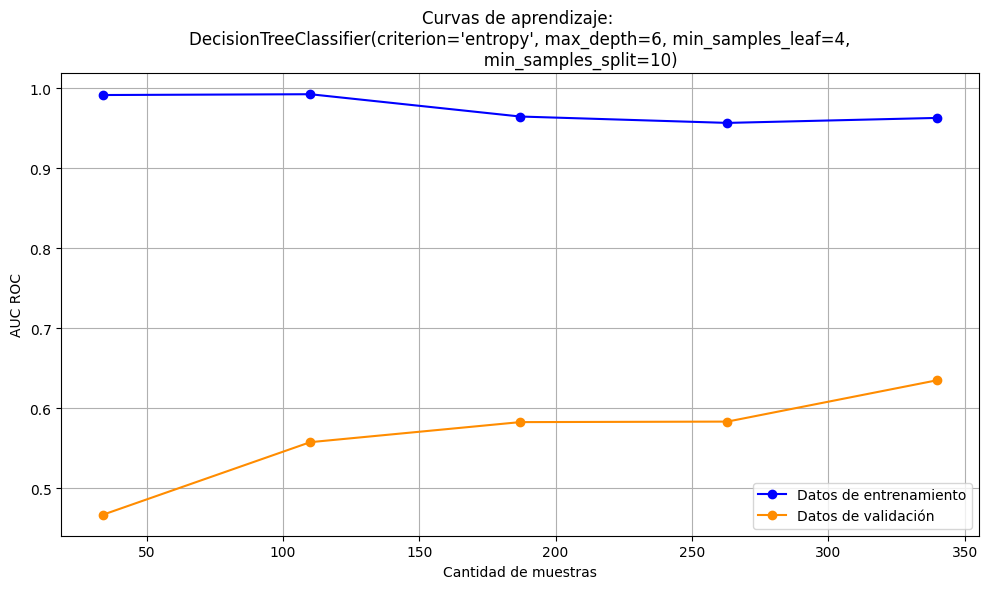

In [32]:
graficar_curvas_aprendizaje(mejor_arbol)

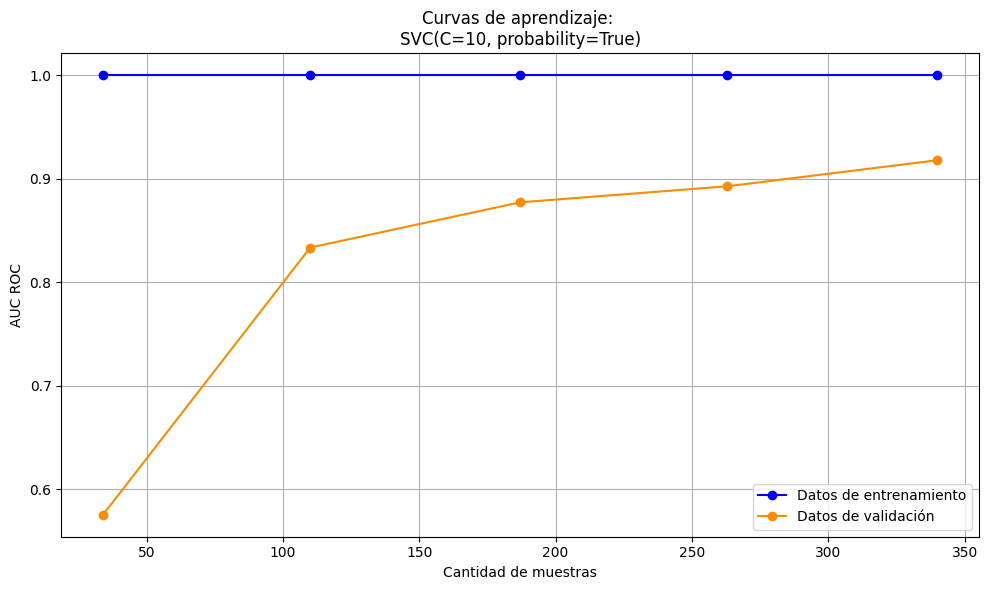

In [33]:
graficar_curvas_aprendizaje(mejor_SVM)

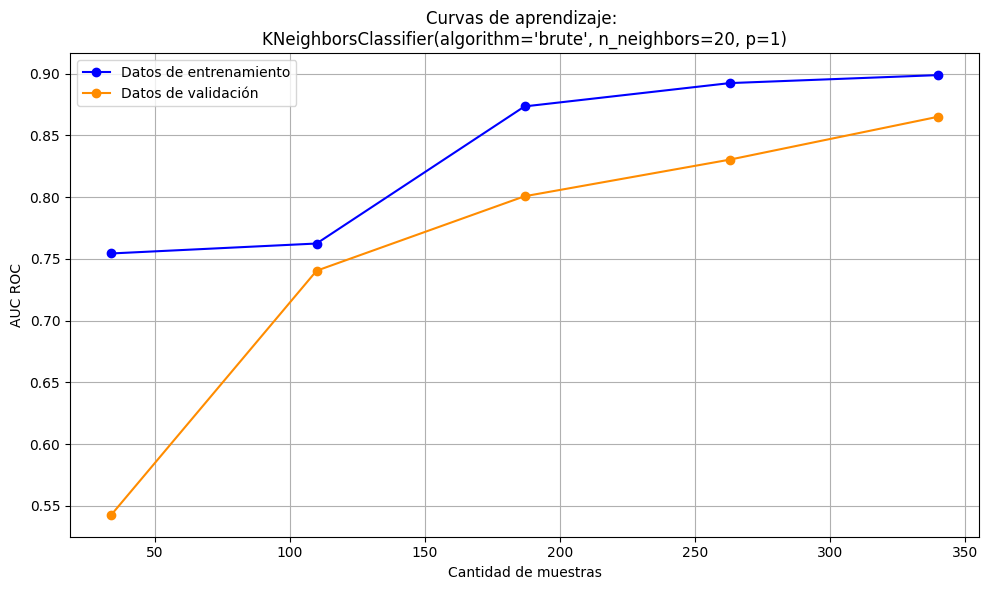

In [34]:
graficar_curvas_aprendizaje(mejor_knn)

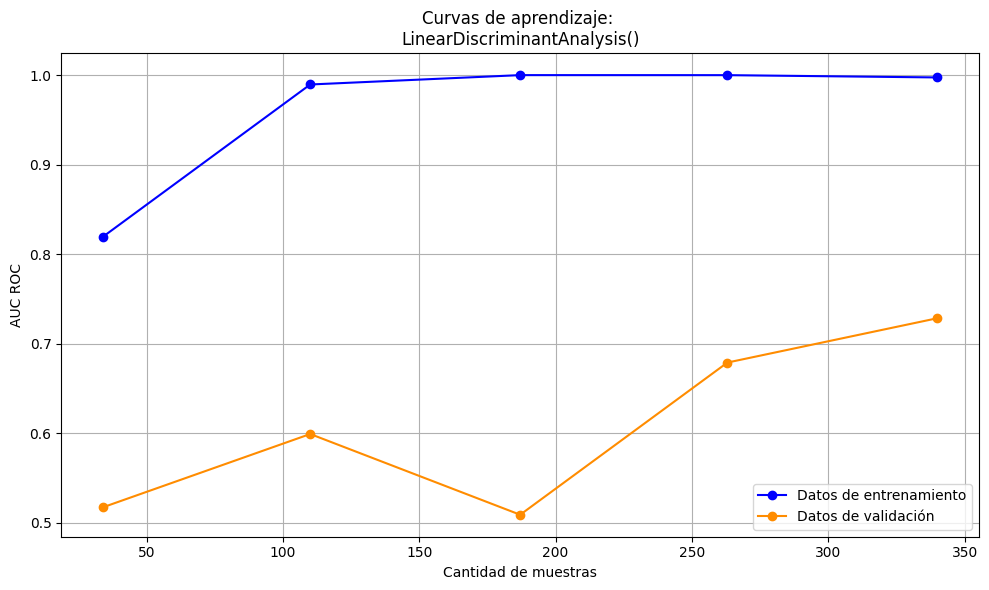

In [35]:
graficar_curvas_aprendizaje(lda)

## Exploración de hiperparámetros de RandomForest

In [36]:
from sklearn.ensemble import RandomForestClassifier

opciones_max_features = [1, "log2", 10, "sqrt", 50, 100, 200]  # ordenados en base a que la cantidad de features es 200.
scores_test, scores_train = [], []

for mf in opciones_max_features:
    rf = RandomForestClassifier(n_estimators=200,
                                max_features=mf,
                                random_state=0)
    
    cv = cross_validate(rf, X_train, y_train, cv=kfolds, scoring='roc_auc', return_train_score=True)
    
    test_score_promedio = cv['test_score'].mean()
    scores_test.append(1 - test_score_promedio)

    train_score_promedio = cv['train_score'].mean()
    scores_train.append(1 - train_score_promedio)

Grafiquemos primero la curva de complejidad, dados los valores explorados de *max_features*:

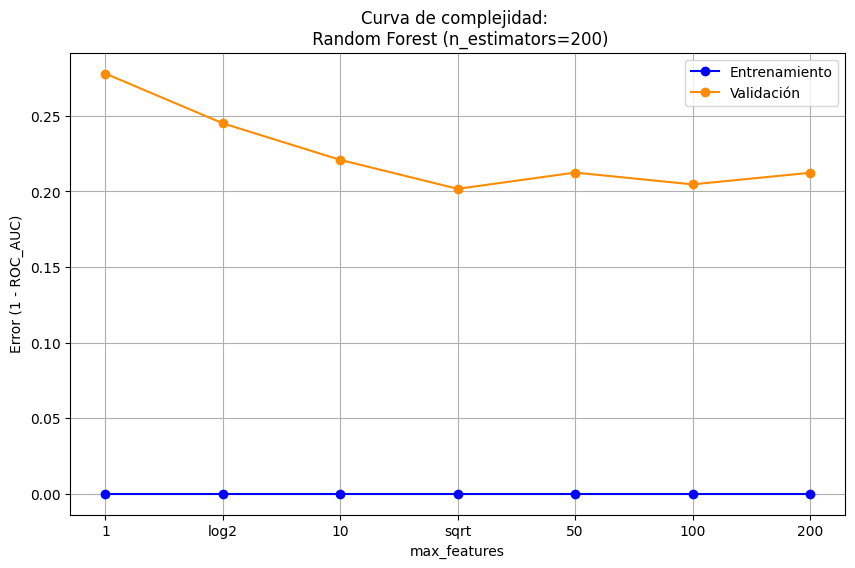

In [37]:
plt.figure(figsize=(10,6))
plt.plot(opciones_max_features, scores_train, label="Entrenamiento", color="blue", marker='o')
plt.plot(opciones_max_features, scores_test, label="Validación", color="darkorange", marker='o')
plt.xlabel("max_features")
plt.ylabel("Error (1 - ROC_AUC)")
plt.title("Curva de complejidad: \n Random Forest (n_estimators=200)")
plt.legend()
plt.grid(True)
plt.show()

El parámetro max_features se utiliza para variar la cantidad de atributos que se pueden utilizar para encontrar el mejor corte cuando se está construyendo cada árbol. Exploramos distintas combinaciones entre 1 y 200, siendo este último la cantidad total de atributos que tiene cada instancia. Se puede observar que, al aumentar max_features, el error en validación tiende a bajar, aunque el mínimo global se alcanza utilizando max_features = sqrt y no con cantidades demasiado grandes de atributos disponibles. Por otro lado, podemos ver también que el error se mantiene constantemente en 0 sin importar la cantidad de atributos que permitamos usar en cada corte.

Usemos el mejor valor observado (en este caso, teniendo en cuenta los errores de validación, ya que en entrenamiento no hay variación), para entrenar un modelo y grafiquemos una curva de aprendizaje:

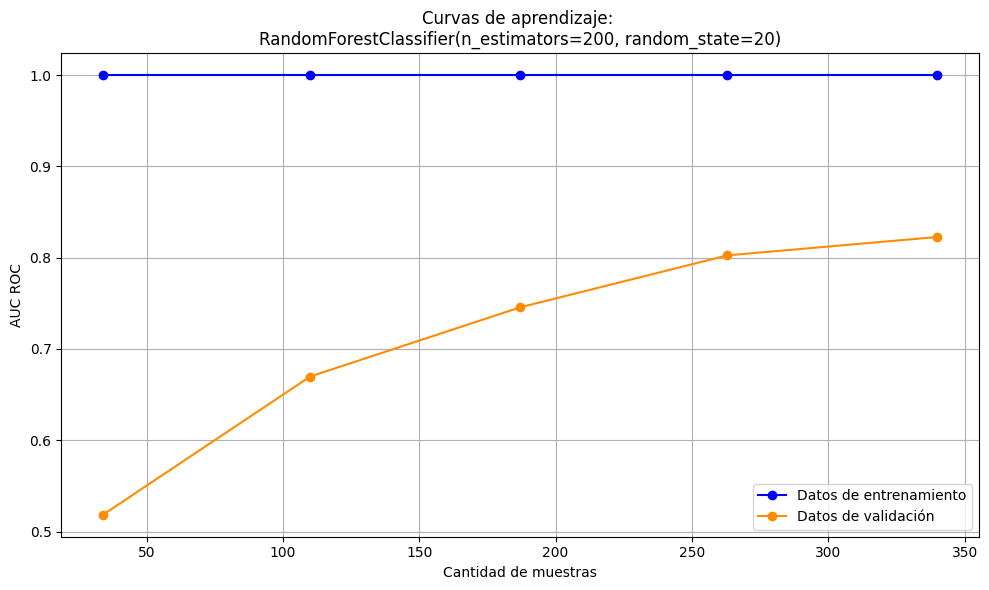

In [38]:
mejor_parametro_mf = opciones_max_features[np.argmin(scores_test)] 

mejor_rf = RandomForestClassifier(n_estimators=200,
                                  max_features=mejor_parametro_mf, random_state=20)

graficar_curvas_aprendizaje(mejor_rf)

# Ejercicio 5

Finalmente, tomamos la mejor configuración de SVM, KNN y Random Forest para testear la performance con los datos de evaluación, para quedarnos con un modelo final.

In [39]:
# Función para hacer las predicciones y calcular el AUC-ROC
def evaluacion_auc_roc(modelo, X_eval, y_eval):
    y_pred = modelo.predict_proba(X_eval)
    return roc_auc_score(y_eval, y_pred[:,1])       # Nos quedamos las probabilidades de la clase positiva.

def evaluacion_accuracy(modelo, X_eval, y_eval):
    y_pred = modelo.predict(X_eval)
    return accuracy_score(y_eval, y_pred)

In [40]:
# Entrenamos Random Forest con los mejores hiperparámetros encontrados y lo evaluamos en el conjunto de evaluación

rf_eval = RandomForestClassifier(n_estimators=200, max_features=mejor_parametro_mf, random_state=20)
rf_eval.fit(X_train, y_train)

rf_eval_auc_roc = evaluacion_auc_roc(rf_eval, X_eval, y_eval)
rf_eval_auc_roc

np.float64(0.8039297658862876)

In [41]:
# Entrenamos SVM con los mejores hiperparámetros encontrados y lo evaluamos en el conjunto de evaluación
svm_eval = svm.SVC(**best_svc_params, probability=True, random_state=0)
svm_eval.fit(X_train, y_train)

svm_eval_auc_roc = evaluacion_auc_roc(svm_eval, X_eval, y_eval)
svm_eval_auc_roc

np.float64(0.9205685618729097)

In [42]:
# Entrenamos KNN con los mejores hiperparámetros encontrados y lo evaluamos en el conjunto de evaluación
knn_eval = KNeighborsClassifier(**best_knn_params)
knn_eval.fit(X_train, y_train)

knn_eval_auc_roc = evaluacion_auc_roc(knn_eval, X_eval, y_eval)
knn_eval_auc_roc

np.float64(0.8632943143812709)

Accuracies

In [43]:
print("SVM: " + str(evaluacion_accuracy(svm_eval, X_eval, y_eval)))
print("Random Forest: " + str(evaluacion_accuracy(rf_eval, X_eval, y_eval)))
print("KNN: " + str(evaluacion_accuracy(knn_eval, X_eval, y_eval)))

SVM: 0.88
Random Forest: 0.7066666666666667
KNN: 0.7866666666666666


El mejor es SVM, por lo que vamos a usarlo como selección final. Notemos que el AUC-ROC de SVM con datos de evaluación da un poco mejor que con los datos de entrenamiento; esto puede deberse a la naturaleza de SVM, que a veces califíca datos de entrenamiento de forma erronea, usando márgenes más laxos, a costa de conseguir una mejor performance en evaluación.

In [44]:
X_held_out = pd.read_csv('../data/X_held_out.csv').to_numpy()           # Cargamos el dataset de held out

y_held_out_pred = svm_eval.predict_proba(X_held_out)[:,1]               # Predecimos con los datos de held out y nos quedamos las probabilidades de la clase positiva.
y_held_out_pred_df = pd.DataFrame(np.round(y_held_out_pred, 4))         # Hacemos un dataframe con las predicciones redondeadas a 4 decimales 

In [48]:
estimacion_auc_roc = str(np.round(svm_eval_auc_roc, 4))                #Estimamos el AUC-ROC para y lo redondeamos a 4 decimales para la entrega

file_name = "04_y_pred_held_out_"+estimacion_auc_roc[2:]+".csv"
y_held_out_pred_df.to_csv(file_name, header=['output'], index=False)